In [3]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import torch

from loss_traces.config import STORAGE_DIR

# from loss_traces.config import MODEL_DIR
from loss_traces.data_processing.data_processing import (
    get_no_shuffle_train_loader,
    get_num_classes,
)
from loss_traces.models.model import load_model
from loss_traces.results.final_model_metrics import get_final_model_metrics
from loss_traces.results.result_processing import (
    get_attackr_scores,
    get_lira_scores,
    get_rmia_scores,
    get_trace_reduction,
)
from loss_traces.results.utils import (
    make_precision_recall_at_k_df_single_threshold,
    make_precision_recall_at_k_df,
)
from loss_traces.attacks import AttackConfig, RMIAAttack
from sklearn.metrics import roc_curve



In [4]:
os.chdir("../")
plt.style.use("plot_style.mplstyle")

In [5]:
os.makedirs("figures", exist_ok=True)
os.makedirs(f"{STORAGE_DIR}/layer_target_indices", exist_ok=True)

In [6]:
os.getcwd()

'/vol/bitbucket/vb524/lossv2'

## WRN28-2 CIFAR10

In [7]:
exp_id = "wrn28-2_CIFAR10"
MODEL_DIR = "trained_models"
config = {
    "dataset": "CIFAR10",
    "arch": "wrn28-2",
    "batchsize": 16,
    "num_workers": 4,
    "augment": True,
    "device": "cuda",
}


def _initialize_model_and_data(config):
    attack_loaders = [
        get_no_shuffle_train_loader(
            config["dataset"],
            config["arch"],
            config["batchsize"],
            config["num_workers"],
        )
    ]

    if config["augment"]:
        attack_loaders.append(
            get_no_shuffle_train_loader(
                config["dataset"],
                config["arch"],
                config["batchsize"],
                config["num_workers"],
                mirror_all=True,
            )
        )

    model = load_model(config["arch"], get_num_classes(config["dataset"])).to(
        config["device"]
    )

    return model, attack_loaders


saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)

model, data_loader = _initialize_model_and_data(config)
model.load_state_dict(saves["model_state_dict"])


<All keys matched successfully>

In [8]:
exp_id = "wrn28-2_CIFAR10"

df = get_lira_scores(exp_id, n_shadows=32)
# df["attackr_score"] = get_attackr_scores(exp_id)
# df["rmia_score"] = get_rmia_scores(exp_id, "target", return_full_df=False)


df["lt_iqr"] = get_trace_reduction(exp_id, reduction="iqr")
members = df[df['target_trained_on'] == True]
top_score = members.sort_values(by='lt_iqr', ascending=False)

In [112]:
top_k = 0.05
idx = int(len(top_score) * top_k)
threshold = top_score.iloc[idx]["lt_iqr"]
np.log(threshold)

np.float64(0.35742282766565103)

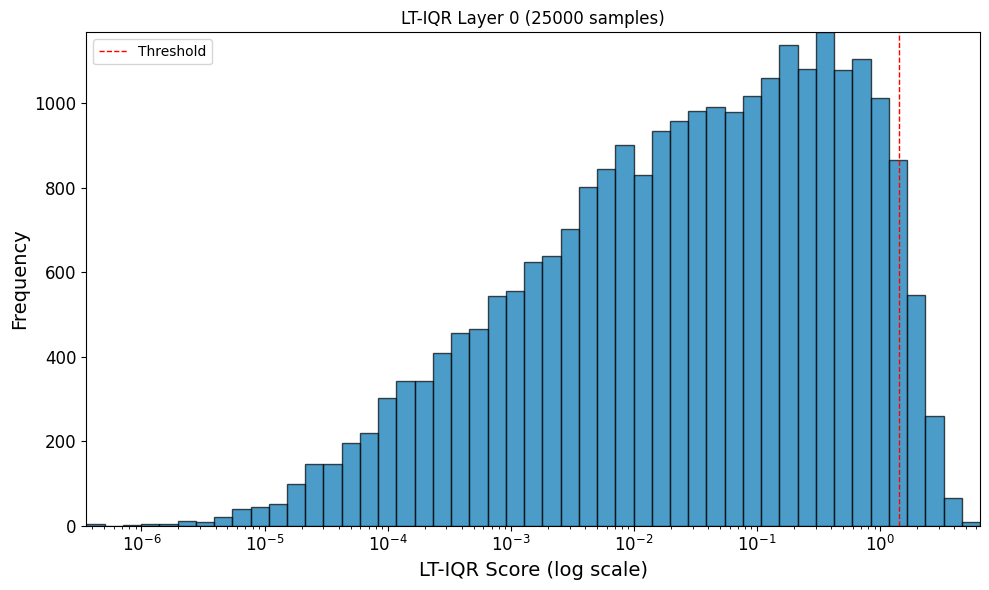

In [115]:
import numpy as np
lt_iqr = top_score["lt_iqr"].values

log_bins = np.logspace(np.log10(lt_iqr.min()), np.log10(lt_iqr.max()), 50)
threshold = lt_iqr[idx]

plt.figure(figsize=(10, 6))
plt.hist(lt_iqr, bins=log_bins, alpha=0.7, edgecolor='black')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=1, label=f'Threshold')
plt.legend()
plt.xscale('log')
plt.title(f"LT-IQR Layer 0 ({len(lt_iqr)} samples)")
plt.xlabel('LT-IQR Score (log scale)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

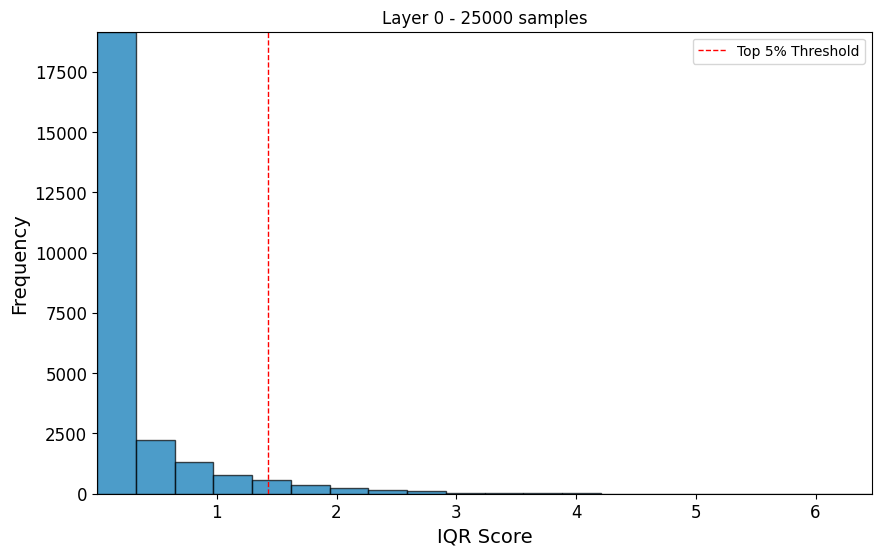

In [76]:
#plot histogram of the iqr scores
top_k = 0.05
idx = int(len(top_score) * top_k)
threshold = top_score.iloc[idx]["lt_iqr"]
plt.figure(figsize=(10, 6))
plt.hist(top_score['lt_iqr'], bins=20, alpha=0.7,  edgecolor='black')
plt.title(f"Layer 0 - {len(top_score)} samples")
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=1,  label=f"Top {top_k*100:.0f}% Threshold")
plt.legend()
plt.xlabel('IQR Score')
plt.ylabel('Frequency')

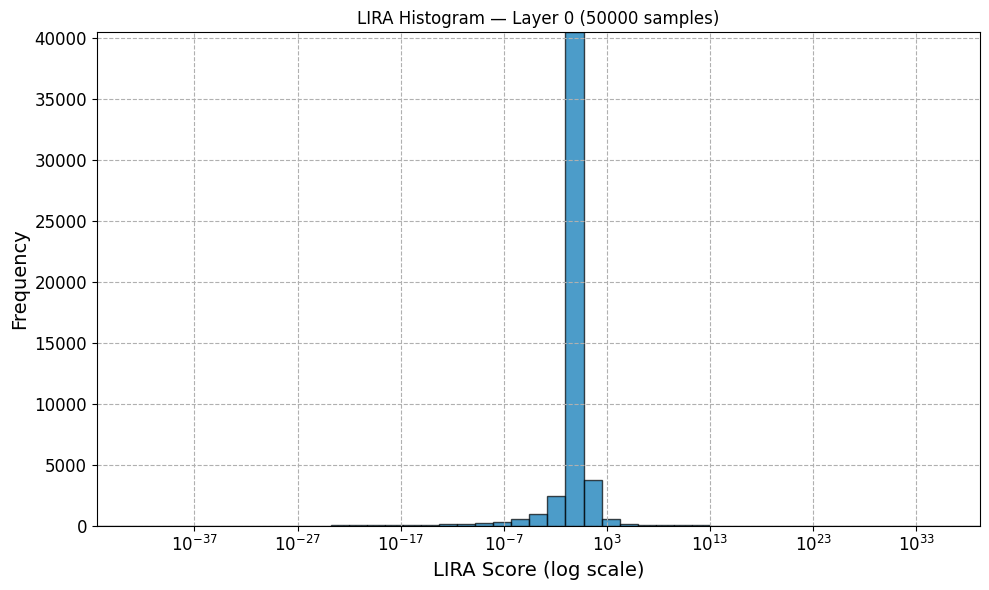

In [117]:
import numpy as np
lira_scores = df["lira_score"].values
lira_scores = lira_scores[lira_scores > 0]
log_bins = np.logspace(np.log10(lira_scores.min()), np.log10(lira_scores.max()), 50)
plt.figure(figsize=(10, 6))
plt.hist(lira_scores, bins=log_bins, alpha=0.7, edgecolor='black')
plt.xscale('log')
plt.title(f"LIRA Histogram — Layer 0 ({len(lira_scores)} samples)")
plt.xlabel('LIRA Score (log scale)')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [ ]:
save_path = f"{STORAGE_DIR}/layer_target_indices/{exp_id}"
os.makedirs(save_path, exist_ok=True)
top_k = 0.05
idx = int(len(top_score) * top_k)
layer = 1
top_score[:idx]['og_idx'].to_csv(
    f"{save_path}/layer_{layer}_vulnerable.csv",
    index=False
)

safe = top_score[idx:]["og_idx"]
safe.to_csv(
    f"{save_path}/layer_{layer}_safe.csv",
    index=False
)

safe.to_pickle(f"{save_path}/layer_{layer}_safe.pkl")

In [8]:
import sklearn.metrics as metrics
def tpr_at_fpr(df, fpr=0.001, cols=["lira_score", "attackr_score", "rmia_score"]):
    labels = df["target_trained_on"]
    results = []
    for col in cols:
        scores = df[col]
        
        fpr_values, tpr_values, thresholds = metrics.roc_curve(labels, scores)
        idx = (np.abs(fpr_values - fpr)).argmin()
        tpr_at_fpr = tpr_values[idx]
        precision = metrics.precision_score(labels, scores > thresholds[idx])
        recall = metrics.recall_score(labels, scores > thresholds[idx])
        auc = metrics.roc_auc_score(labels, scores)
        
        results.append({
            'attack': col,
            f'tpr_at_fpr_{fpr}': tpr_at_fpr,
            'auc': auc,
            'precision': precision,
            'recall': recall
        })

    result_df = pd.DataFrame(results)
    return result_df

def calculate_roc(df: pd.DataFrame, cols=["lira_score", "attackr_score", "rmia_score"]):
    """
    Calculates FPR and TPR for each column in cols and adds them as new columns to the DataFrame.
    Returns a dictionary with attack names as keys and (fpr, tpr) tuples as values.
    """
    roc_data = {}
    for target_col in cols:
        fpr, tpr, _ = metrics.roc_curve(df['target_trained_on'], df[target_col])
        roc_data[target_col] = (fpr, tpr)
    return roc_data


def plot_roc(roc_data, save_path=None):
    """
    Plots ROC curves from roc_data (dict of {label: (fpr, tpr)}).
    Optionally, extra_curves (list of (fpr, tpr)) and extra_labels (list of str)
    can be provided.
    """
    plt.figure(figsize=(8, 6))
    for label, (fpr, tpr) in roc_data.items():
        if label == "rmia_score":
            label = "RMIA"
        elif label == "attackr_score":
            label = "AttackR"
        elif label == "lira_score":
            label = "LiRA"
        plt.plot(fpr, tpr, label=label)
    plt.plot(
        [0, 1], [0, 1],
        linestyle='--',
        color='gray',
        label='Random Guessing'
    )
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(bottom=0.001)
    plt.xlim(left=0.001)
    plt.grid(True)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()    

In [9]:
tpr_df = tpr_at_fpr(df, fpr=0.001, cols=["lira_score"])
tpr_df

,attack,tpr_at_fpr_0.001,auc,precision,recall
0,lira_score,0.0468,0.695456,0.979899,0.0468


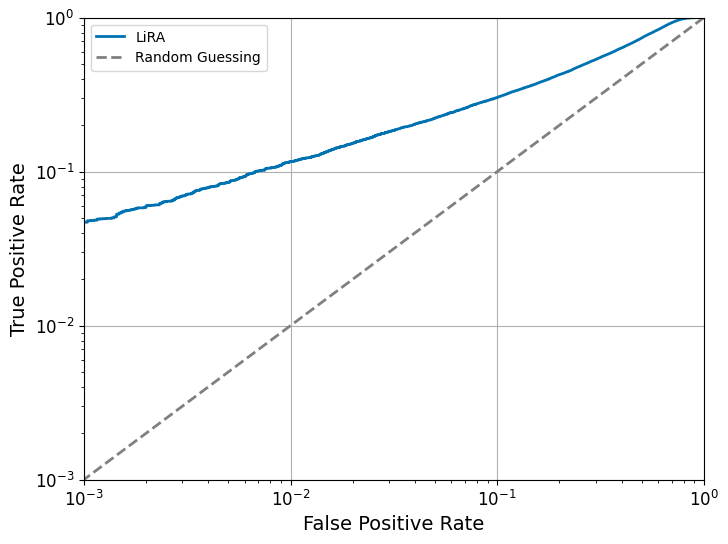

In [10]:
plot_roc(calculate_roc(df, cols=["lira_score"]),
         save_path="figures/roc_lira.png")

In [ ]:
save_path = f"{STORAGE_DIR}/layer_target_indices/{exp_id}"
os.makedirs(save_path, exist_ok=True)
top_k = 0.05
idx = int(len(top_score) * top_k)
layer = 1
top_score[:idx]['og_idx'].to_csv(
    f"{save_path}/layer_{layer}_vulnerable.csv",
    index=False
)

safe = top_score[idx:]["og_idx"]
safe.to_csv(
    f"{save_path}/layer_{layer}_safe.csv",
    index=False
)

safe.to_pickle(f"{save_path}/layer_{layer}_safe.pkl")

In [12]:
features = {'my_layer': []}  # initialize as list BEFORE any forward pass
features

{'my_layer': []}

In [13]:
features = {'my_layer': []}  # initialize as list BEFORE any forward pass

def hook_fn(module, input, output):
    features['my_layer'].append(output.detach().cpu())

hook = model.relu.register_forward_hook(hook_fn)

model.eval()
with torch.no_grad():
    for batch in data_loader[0]:
        input_tensor = batch[0].to(config['device'])
        _ = model(input_tensor)

hook.remove()

# concatenate once after all batches processed
features['my_layer'] = torch.cat(features['my_layer'], dim=0)

print(features['my_layer'].shape)


torch.Size([50000, 128, 8, 8])


In [14]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# filter features if in saves[trained_on]
filter = saves["trained_on_indices"]
filtered_features = features["my_layer"][filter]
data_len = filtered_features.shape[0]
vulnerable_indices = top_score[:idx]['og_idx'].values
labels = [1 if x in vulnerable_indices else 0 for x in range(data_len)]

flattened = filtered_features.view(filtered_features.size(0), -1)  # flatten per sample

# tsne = TSNE(n_components=2, random_state=42, verbose=1, n_iter=1000, perplexity=30)

# tsne_results = tsne.fit_transform(flattened.cpu().numpy())

In [15]:
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, alpha=0.25, cmap='coolwarm')
plt.title("t-SNE of Penultimate Layer (WRN)")
plt.show()

NameError: name 'tsne_results' is not defined

<Figure size 1000x800 with 0 Axes>

In [16]:
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [umap-learn]2 [umap-learn]
Note: you may need to restart the kernel to use updated packages.


In [32]:
from umap import UMAP

# umap_result = UMAP(n_components=2).fit_transform(flattened.numpy())
umap_result = UMAP(n_components=2, random_state=42).fit_transform(flattened.cpu().numpy())

/vol/bitbucket/vb524/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [34]:
umap_result.shape

(25000, 2)

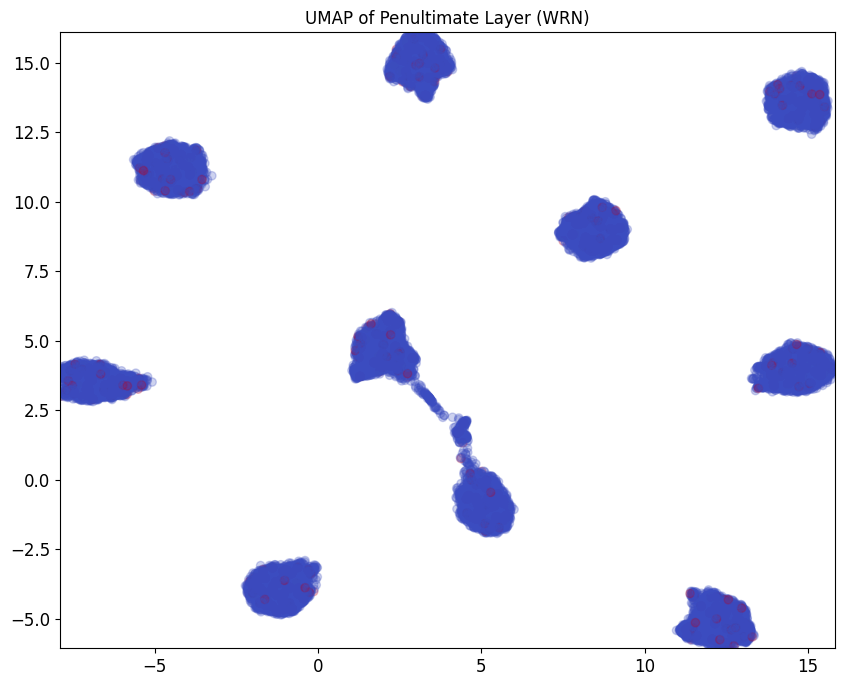

In [ ]:


plt.figure(figsize=(10, 8))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, alpha=0.25, cmap='coolwarm')
plt.title("UMAP of Penultimate Layer (WRN)")
plt.show()

In [ ]:
for name, module in model.named_modules():
    print(name)


conv1
block1
block1.layer
block1.layer.0
block1.layer.0.bn1
block1.layer.0.relu1
block1.layer.0.conv1
block1.layer.0.bn2
block1.layer.0.relu2
block1.layer.0.conv2
block1.layer.0.convShortcut
block1.layer.1
block1.layer.1.bn1
block1.layer.1.relu1
block1.layer.1.conv1
block1.layer.1.bn2
block1.layer.1.relu2
block1.layer.1.conv2
block1.layer.2
block1.layer.2.bn1
block1.layer.2.relu1
block1.layer.2.conv1
block1.layer.2.bn2
block1.layer.2.relu2
block1.layer.2.conv2
block1.layer.3
block1.layer.3.bn1
block1.layer.3.relu1
block1.layer.3.conv1
block1.layer.3.bn2
block1.layer.3.relu2
block1.layer.3.conv2
block2
block2.layer
block2.layer.0
block2.layer.0.bn1
block2.layer.0.relu1
block2.layer.0.conv1
block2.layer.0.bn2
block2.layer.0.relu2
block2.layer.0.conv2
block2.layer.0.convShortcut
block2.layer.1
block2.layer.1.bn1
block2.layer.1.relu1
block2.layer.1.conv1
block2.layer.1.bn2
block2.layer.1.relu2
block2.layer.1.conv2
block2.layer.2
block2.layer.2.bn1
block2.layer.2.relu1
block2.layer.2.conv1